In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA

%matplotlib inline

# getting the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/My Drive/тинькофф/сем 5 feature engineering'

/content/drive/My Drive/тинькофф/сем 5 feature engineering


In [ ]:
def delete_target(X):
  y = X['TARGET']
  X = X.drop(columns=['TARGET'])
  return X, y

In [ ]:
data = pd.read_csv('train-2.csv', delimiter=',')
X, y = delete_target(data)


In [ ]:
X.head(1)

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10


In [ ]:
X.shape

(34546, 15)

In [ ]:
X.columns

Index(['Id', 'bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address'],
      dtype='object')

In [ ]:
X.head(4)

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street


In [ ]:
X.isna().sum()

Id                    0
bathrooms             0
bedrooms              0
building_id           0
created               0
description        1037
display_address      88
features              0
latitude              0
listing_id            0
longitude             0
manager_id            0
photos                0
price                 0
street_address        4
dtype: int64

In [ ]:
X.dtypes

Id                   int64
bathrooms          float64
bedrooms             int64
building_id         object
created             object
description         object
display_address     object
features            object
latitude           float64
listing_id           int64
longitude          float64
manager_id          object
photos              object
price                int64
street_address      object
dtype: object

# preprocessing

In [ ]:
def drop_useless(X):
  return X.drop(columns=['Id', 'building_id', 'listing_id', 'manager_id'])

def extract_features(X):
  pass

def delete_features(X):
  return X.drop(columns=['description', 'display_address', 'street_address']) # 'description' 'features'

def fill_nans(X):
  return X.replace(np.nan, 'None')

def check_types(X):
  X['bathrooms'] = X['bathrooms'].astype(np.int)
  return X

def date_prepocess(df):
    def date_parser(datestr):
      return pd.datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S')
    
    df['created'].apply(date_parser)
    #df['month'] = df['created'].dt.month
    df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
    df['hour'] = df['created'].dt.hour
    df['weekday'] = df['created'].dt.weekday

    return df.drop(columns = ['created'])

def extract_photos(X):
  X['photos'] = X['photos'].apply(lambda x: len(x.split("', '"))).astype(np.int64)
  return X

def createDTM(messages, X):
    vect = TfidfVectorizer(max_features= 20)

    dtm = vect.fit_transform(messages) # create DTM
    
    # create pandas dataframe of DTM
    return pd.concat([X.drop(columns=['description']), pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())], axis = 1), vect
    


In [ ]:
X

# features

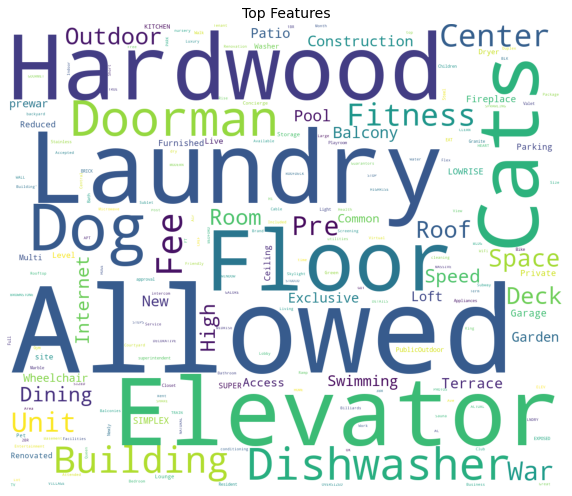

In [ ]:
from wordcloud import WordCloud

list_of_features = list(X['features'].values)
plt.figure(figsize = (10, 10))

a = []

for i in list_of_features:
  a += (i[2:-2].split("', '"))

text = ' '.join(a)

wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False, width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top Features', fontsize=14)
plt.axis("off")
plt.show()

In [ ]:
import itertools
from collections import Counter

top_25_features = [x for x, y in Counter(a).most_common(25)]
top_25_features

['Elevator',
 'Hardwood Floors',
 'Cats Allowed',
 'Dogs Allowed',
 'Doorman',
 'Dishwasher',
 'No Fee',
 'Laundry in Building',
 'Fitness Center',
 'Pre-War',
 'Laundry in Unit',
 'Roof Deck',
 'Outdoor Space',
 'Dining Room',
 'High Speed Internet',
 '',
 'Balcony',
 'Swimming Pool',
 'Laundry In Building',
 'New Construction',
 'Terrace',
 'Exclusive',
 'Loft',
 'Garden/Patio',
 'Wheelchair Access']

In [ ]:
def get_features(x):
    if len(x)==0:
        return ['no_feature', ]
    
    features = [feature for feature in x if feature in top_25_features]
    if len(features)==0:
        features.append('other')
    return features

In [ ]:
get_features(X['features'][3][2:-2].split("', '"))

['Swimming Pool',
 'Doorman',
 'Elevator',
 'Fitness Center',
 'Laundry in Unit',
 'Dishwasher',
 'Hardwood Floors',
 'No Fee']

In [ ]:
def make_feature_data(X, top_25_features):
  a = np.zeros((X['features'].shape[0], 25))

  for j in np.arange(X['features'].shape[0]):
    row = np.zeros(25)

    for i in get_features(X['features'][j][2:-2].split("', '")):
      if i in top_25_features:
        row[top_25_features.index(i)] = 1
    
    a[j,:] = row

  return pd.DataFrame(a, columns=[i + '_1' for i in top_25_features]).astype(int)

In [ ]:
make_feature_data(X, top_25_features)

,Elevator_1,Hardwood Floors_1,Cats Allowed_1,Dogs Allowed_1,Doorman_1,Dishwasher_1,No Fee_1,Laundry in Building_1,Fitness Center_1,Pre-War_1,Laundry in Unit_1,Roof Deck_1,Outdoor Space_1,Dining Room_1,High Speed Internet_1,_1,Balcony_1,Swimming Pool_1,Laundry In Building_1,New Construction_1,Terrace_1,Exclusive_1,Loft_1,Garden/Patio_1,Wheelchair Access_1
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34541,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34542,0,1,1,1,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
34543,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
34544,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = pd.read_csv('train-2.csv', delimiter=',')
X, y = delete_target(X)

X = pd.concat([X.drop(columns = 'features'), make_feature_data(X, top_25_features)], axis = 1)

In [ ]:


X = check_types(X)

X = date_prepocess(X)
X = extract_photos(X)

X = drop_useless(X)
X = delete_features(X)
X = fill_nans(X)
#X, vect = createDTM(X.description, X)

X['price'] = np.log(X['price'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [ ]:
X.head(4)

,bathrooms,bedrooms,latitude,longitude,photos,price,Elevator_1,Hardwood Floors_1,Cats Allowed_1,Dogs Allowed_1,Doorman_1,Dishwasher_1,No Fee_1,Laundry in Building_1,Fitness Center_1,Pre-War_1,Laundry in Unit_1,Roof Deck_1,Outdoor Space_1,Dining Room_1,High Speed Internet_1,_1,Balcony_1,Swimming Pool_1,Laundry In Building_1,New Construction_1,Terrace_1,Exclusive_1,Loft_1,Garden/Patio_1,Wheelchair Access_1,hour,weekday,and,apartment,bedroom,br,building,com,for,in,is,kitchen,new,of,on,or,room,the,this,to,website_redacted,with
0,1,3,40.7647,-73.9918,3,8.410721,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,3,0.414621,0.545614,0.0,0.000000,0.000000,0.000000,0.179882,0.147963,0.000000,0.000000,0.215558,0.334044,0.217132,0.000000,0.0,0.149850,0.360294,0.305005,0.000000,0.160162
1,1,1,40.7275,-74.0322,13,7.851661,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,0.621649,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.783296,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,0,40.7798,-73.9751,6,7.492760,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.191089,0.000000,0.0,0.428747,0.257554,0.000000,0.000000,0.000000,0.254589,0.000000,0.298037,0.000000,0.600427,0.000000,0.0,0.207187,0.249076,0.210854,0.223043,0.000000
3,1,2,40.7081,-74.0065,4,8.131531,1,1,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5,3,0.379003,0.249372,0.0,0.425185,0.085138,0.094742,0.246644,0.202879,0.084158,0.079593,0.098520,0.229011,0.000000,0.097097,0.0,0.616396,0.000000,0.139402,0.073730,0.073201


In [ ]:
X.columns

Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'photos', 'price',
       'Elevator_1', 'Hardwood Floors_1', 'Cats Allowed_1', 'Dogs Allowed_1',
       'Doorman_1', 'Dishwasher_1', 'No Fee_1', 'Laundry in Building_1',
       'Fitness Center_1', 'Pre-War_1', 'Laundry in Unit_1', 'Roof Deck_1',
       'Outdoor Space_1', 'Dining Room_1', 'High Speed Internet_1', '_1',
       'Balcony_1', 'Swimming Pool_1', 'Laundry In Building_1',
       'New Construction_1', 'Terrace_1', 'Exclusive_1', 'Loft_1',
       'Garden/Patio_1', 'Wheelchair Access_1', 'hour', 'weekday', 'and',
       'apartment', 'bedroom', 'br', 'building', 'com', 'for', 'in', 'is',
       'kitchen', 'new', 'of', 'on', 'or', 'room', 'the', 'this', 'to',
       'website_redacted', 'with'],
      dtype='object')

In [ ]:
d = pd.get_dummies(y)
d.columns = ['high_1', 'medium_1', 'low_1']
cor_df = pd.concat([X, d], axis = 1)

corr = cor_df.corr()
corr.style.background_gradient(cmap='coolwarm')

# model declaration

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

In [ ]:
from collections import Counter
class_weight = dict(Counter(y_train))
Counter(y_train)

Counter({'high': 2664, 'low': 23752, 'medium': 7784})

In [ ]:
a = [1 / 1904, 1 / 16782, 1 / 5496]
a

[0.0005252100840336134, 5.9587653438207606e-05, 0.0001819505094614265]

In [ ]:
lr = LogisticRegression(max_iter=5000, random_state=42, class_weight={'high': 1, 'low':  0.2, 'medium': 0.5})

lr.fit(X_train, y_train)
preds =  lr.predict(X_test)



In [ ]:
Counter(preds)

Counter({'high': 31, 'low': 218, 'medium': 97})

In [ ]:
Counter(y_test)

Counter({'high': 23, 'low': 247, 'medium': 76})

In [ ]:
print(accuracy_score(y_test, preds))
print(accuracy_score(y_train, lr.predict(X_train)))

0.6770551910459283
0.678727979488876


In [ ]:
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_train, lr.predict(X_train), average='macro'))

0.5162029295481926
0.5176095269294206


In [ ]:
cross_val_score(lr, X, y, cv=5, scoring='accuracy')

KeyboardInterrupt: ignored

# Test Prediction

In [ ]:
def createDTM_test(messages, vect):
    dtm = vect.transform(messages) # create DTM
    
    # create pandas dataframe of DTM
    return pd.concat([X_new.drop(columns=['description']), pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())], axis = 1)

def fill_nans_test(X):
  return X.replace(np.nan, 0)

In [ ]:

"""
X = check_types(X)

X = date_prepocess(X)
X = extract_photos(X)

X = drop_useless(X)
X = delete_features(X)
X = fill_nans(X)
#X, vect = createDTM(X.description, X)

X['price'] = np.log(X['price'])"""

X_new = pd.read_csv('test-2.csv', delimiter=',')
IDS = X_new['Id']

X_new = pd.concat([X_new.drop(columns = 'features'), make_feature_data(X_new, top_25_features)], axis = 1)

X_new = check_types(X_new)

X_new = date_prepocess(X_new)
X_new = extract_photos(X_new)

X_new = drop_useless(X_new)
X_new = delete_features(X_new)
X_new= fill_nans(X_new)

X_new['price'] = np.log(X_new['price'])

#X_new = createDTM_test(X_new, vect)
#X_new = fill_nans_test(X_new)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [ ]:
X_new

,bathrooms,bedrooms,latitude,longitude,photos,price,Elevator_1,Hardwood Floors_1,Cats Allowed_1,Dogs Allowed_1,Doorman_1,Dishwasher_1,No Fee_1,Laundry in Building_1,Fitness Center_1,Pre-War_1,Laundry in Unit_1,Roof Deck_1,Outdoor Space_1,Dining Room_1,High Speed Internet_1,_1,Balcony_1,Swimming Pool_1,Laundry In Building_1,New Construction_1,Terrace_1,Exclusive_1,Loft_1,Garden/Patio_1,Wheelchair Access_1,hour,weekday,and,apartment,bedroom,br,building,com,for,in,is,kitchen,new,of,on,or,room,the,this,to,website_redacted,with
0,2,3,40.7716,-73.9544,8,8.449984,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,40.7944,-73.9401,4,7.649693,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,40.7650,-73.9882,7,7.937375,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,3,40.7288,-73.9808,7,8.612503,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,3,40.7864,-73.9713,10,8.292799,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14801,1,1,40.7437,-73.9585,1,8.137396,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14802,1,2,40.7490,-73.9991,8,8.342840,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14803,1,2,40.7238,-73.8623,13,7.495542,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,9,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14804,1,1,40.7075,-74.0043,3,8.109225,1,1,0,0,1,1,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_new.columns

Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'photos', 'price',
       'Elevator_1', 'Hardwood Floors_1', 'Cats Allowed_1', 'Dogs Allowed_1',
       ...
       'unit', 'viewing', 'views', 'washer', 'website_redacted', 'windows',
       'with', 'york', 'you', 'your'],
      dtype='object', length=133)

In [ ]:
X.columns

Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'photos', 'price',
       'Elevator_1', 'Hardwood Floors_1', 'Cats Allowed_1', 'Dogs Allowed_1',
       ...
       'unit', 'viewing', 'views', 'washer', 'website_redacted', 'windows',
       'with', 'york', 'you', 'your'],
      dtype='object', length=133)

In [ ]:
preds_final = lr.predict(X_new)
Counter(preds_final)

Counter({'high': 1492, 'low': 8901, 'medium': 4413})

In [ ]:
preds_final_df = pd.DataFrame({'Id': IDS, 'TARGET': preds_final})

In [ ]:
preds_final_df['TARGET'].unique()

array(['medium', 'low', 'high'], dtype=object)

In [ ]:
from google.colab import files
preds_final_df.to_csv('fhouse.csv', index=False) 
files.download('fhouse.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data = pd.read_json('/content/train.json')

In [ ]:
data.loc[19477:19478]

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
19477,2.0,3,87c4e08083ac83618dd9fdbf849331fe,2016-06-21 03:21:59,Rent listed is net effective after one month f...,E 77 St.,"[Pre-War, Laundry in Unit, Dishwasher, Hardwoo...",40.7716,7189305,-73.9544,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7189305_f47ed5c0...,4675,339 E 77 St.,low
